In [ ]:
import os
import jax

os.chdir("..")
import numpy as np
from flax import serialization

from src.c3po.analysis.analysis import C3poAnalysis
from src.c3po.model.model import C3PO

# analysis=C3poAnalysis(None, None, None)

# Loading

## Load in data objects

In [19]:
import numpy as np
from scipy.io import loadmat

data = loadmat(
    "/stelmo/sam/c3po_results/moserdata.mat"
)  # in the downloadable Vollan archive, this is 27765_2.mat  (potentially can do this with any other data file)


def mat_fields(s):
    """Return field names for a MATLAB struct (np.void or structured ndarray)."""
    if isinstance(s, np.ndarray) and s.dtype.names:
        return s.dtype.names
    if isinstance(s, np.void) and s.dtype.names:
        return s.dtype.names
    raise TypeError("Not a MATLAB struct (np.void/structured ndarray).")


# The 'Dsession' key gives the main struct
Dsession = data["Dsession"]

t = Dsession["t"][0, 0].flatten()  # times
x = Dsession["x"][0, 0].flatten()  # x positions
y = Dsession["y"][0, 0].flatten()  # y positions
speed = Dsession["speed"][0, 0].flatten()  #
thetaphase = Dsession["theta"][0, 0].flatten()  #
units = Dsession["units"][0, 0].flatten()  # unit data (more parsing below)
unit_cluster_id = units["mec"][0]["acorrCluId"][:]

## Load in encoding results

In [ ]:
from src.c3po.tables.dev_tables import C3POStorage

C3POStorage()  # .alter()
key = {"model_name": "mec_wavenet_all_cells"}
analysis = (C3POStorage & key).fetch_analysis_object()

analysis.load_embedding(f"/stelmo/sam/c3po_results/{key['model_name']}_embedding.npz")

t_interp = np.arange(analysis.t[0], analysis.t[-1], 0.001)
analysis.interpolate_context(t_interp)
analysis.fit_context_pca()

# Just showing how to access the variables
t = analysis.t
z = analysis.z
c = analysis.c
c_pca = analysis.c_pca
t_interp = analysis.t_interp
c_interp = analysis.c_interp
c_pca_interp = analysis.c_pca_interp

z_stacked (1, 1, 99, 16)
Z (1, 100, 16) pos_params (1, 1, 99, 1)
neg_z (1, 1, 100, 16)
c (1, 100, 16)
neg_params (1, 1, 99, 1)


In [ ]:
model_args = dict(
    encoder_args=entry["encoder_args"],
    context_args=entry["context_args"],
    rate_args=entry["rate_args"],
    distribution=entry.get("distribution", "poisson"),
    latent_dim=entry["latent_dim"],
    context_dim=entry["context_dim"],
    n_neg_samples=1,
    predicted_sequence_length=1,
    sample_params=None,
)

model = C3PO(**model_args)

x_ = np.zeros((1, 100, entry["input_shape"]))
delta_t_ = np.zeros(
    (
        1,
        100,
    )
)
rand_key = jax.random.PRNGKey(0)
null_params = model.init(jax.random.PRNGKey(1), x_, delta_t_, rand_key)
params = serialization.from_bytes(null_params, entry["learned_params"])

z_stacked (1, 1, 99, 16)
Z (1, 100, 16) pos_params (1, 1, 99, 1)
neg_z (1, 1, 100, 16)
c (1, 100, 16)
neg_params (1, 1, 99, 1)


# Analysis

In [17]:
import matplotlib.pyplot as plt
from spyglass.common.common_interval import Interval

### Plot example

[3.61147219e+01 1.60296483e+01 1.33110737e+01 9.73207936e+00
 7.85589011e+00 5.90265340e+00 4.81017816e+00 3.60732089e+00
 1.36479789e+00 5.17506970e-01 3.55634333e-01 1.30875571e-01
 1.10222161e-01 8.63794236e-02 4.21763833e-02 2.88415018e-02]


Text(0, 0.5, 'context variables')

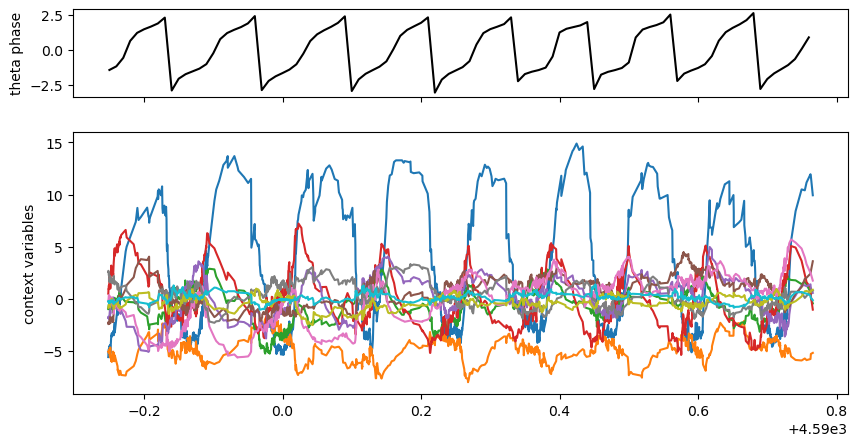

In [20]:
fig, ax = plt.subplots(nrows=2, sharex=True, height_ratios=[1, 3], figsize=(10, 5))
ind = slice(11000, 12300)
# ind = slice(12000,12300)

ax[1].plot(analysis.t[ind], analysis.c_pca[ind, :10])
plot_interval = Interval(np.array([[analysis.t[ind][0], analysis.t[ind][-1]]]))
behavior_inds = plot_interval.contains(t, as_indices=True)
ax[0].plot(t[behavior_inds], thetaphase[behavior_inds], c="k")
print(analysis.pca.explained_variance_ratio_ * 100)
ax[0].set_ylabel("theta phase")
ax[1].set_ylabel("context variables")

### Average context value vs phase

Text(0.5, 0, 'Theta phase (rad)')

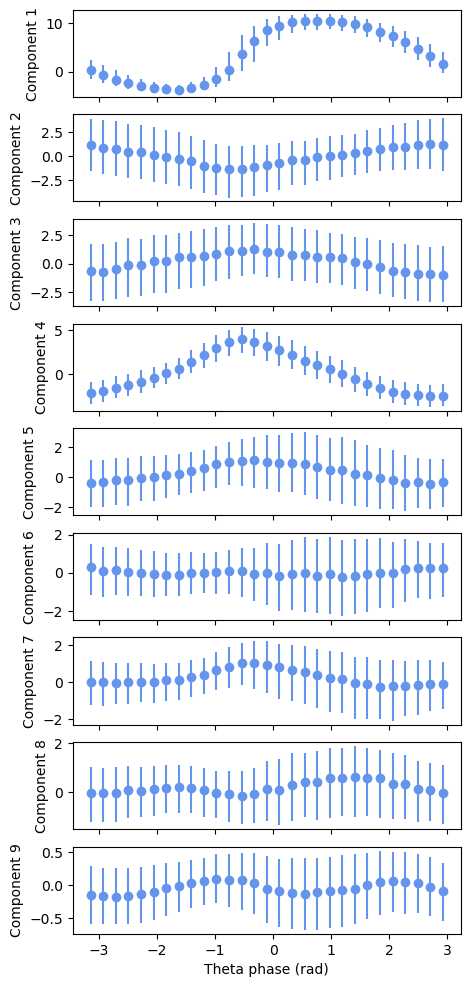

In [21]:
context_binned, bins = analysis.bin_context_by_feature(
    thetaphase, t, bins=np.linspace(-np.pi, np.pi, 30), pca=True
)

fig, ax = plt.subplots(nrows=9, sharex=True, figsize=(5, 12))
for dat, loc in zip(context_binned, bins):
    for i, a in enumerate(ax):
        color = "cornflowerblue"
        a.scatter(loc, np.median(dat[:, i]), c=color)
        a.vlines(
            loc, np.percentile(dat[:, i], 25), np.percentile(dat[:, i], 75), color=color
        )
for i, a in enumerate(ax):
    a.set_ylabel(f"Component {i+1}")
plt.xlabel("Theta phase (rad)")

### 2d density distribution of context variables

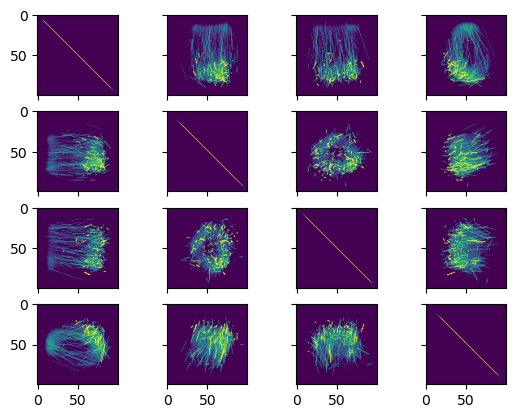

In [24]:
c_pca = analysis.c_pca_interp
# ind = running_intervals.contains(analysis.t, as_indices=True)
# ind = no_gap_intervals.contains(analysis.t_interp, as_indices=True)
ind = np.arange(c_pca.shape[0])

n_plot = 4
fig, ax = plt.subplots(nrows=n_plot, ncols=n_plot, sharex="col", sharey="row")

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        pc_ind = (i, j)
        H, bx, by = np.histogram2d(
            c_pca[ind, pc_ind[0]], c_pca[ind, pc_ind[1]], bins=100
        )
        H += 1e-3
        H = H / H.sum()
        H = np.log10(H)

        ax[i, j].imshow(H, clim=(-4, -3))
# plt.colorbar()

# plt.scatter(c_pca_interp[ind, 4], c_pca_interp[ind, 2], s=1, alpha=0.01)
# plt.scatter(c_pca_interp[ind, 2], c_pca_interp[ind, 3], s=1, alpha=0.1)

### Average Context values vs 2d position

/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


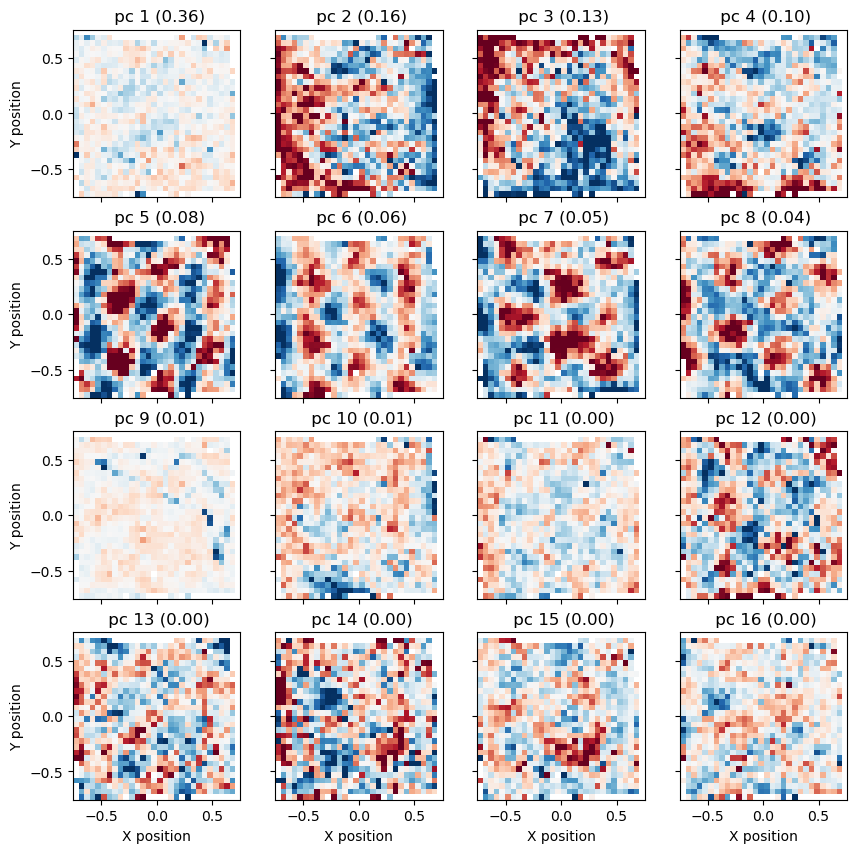

In [28]:
bins = np.linspace(np.min(x), np.max(x), 30)
c_binned, bins_x, bins_y = analysis.bin_context_by_feature_2d(
    x, t, y, t, pca=True, bins_1=bins, bins_2=bins
)
h = np.zeros(
    (bins_x.size, bins_y.size, analysis.context_dim),
)

for i in range(h.shape[0]):
    for j in range(h.shape[1]):
        if len(c_binned[i][j]) == 0:
            h[i, j] = np.nan
        h[i, j] = np.mean(c_binned[i][j], axis=0)

fig, ax = plt.subplots(
    nrows=min(4, analysis.latent_dim),
    ncols=4,
    figsize=(10, 10),
    sharex=True,
    sharey=True,
)
for i, a in enumerate(ax.ravel()):
    if i >= analysis.context_dim:
        break
    c_rng = np.nanmax(np.abs(h[:, :, i])) * 0.5
    a.imshow(
        h[:, :, i].T,
        aspect=1,
        origin="lower",
        extent=(bins_x[0], bins_x[-1], bins_y[0], bins_y[-1]),
        cmap="RdBu",
        clim=(-c_rng, c_rng),
    )
    # a.set_title(f"Latent dimension {i+1}")
    # a.set_xlabel("X position (cm)")
    a.set_title(f" pc {i+1} ({analysis.pca.explained_variance_ratio_[i]:.2f})")

for a in ax[:, 0]:
    a.set_ylabel("Y position")


for a in ax[-1, :]:
    a.set_xlabel("X position")

### Similarity matrix of neuron embeddings

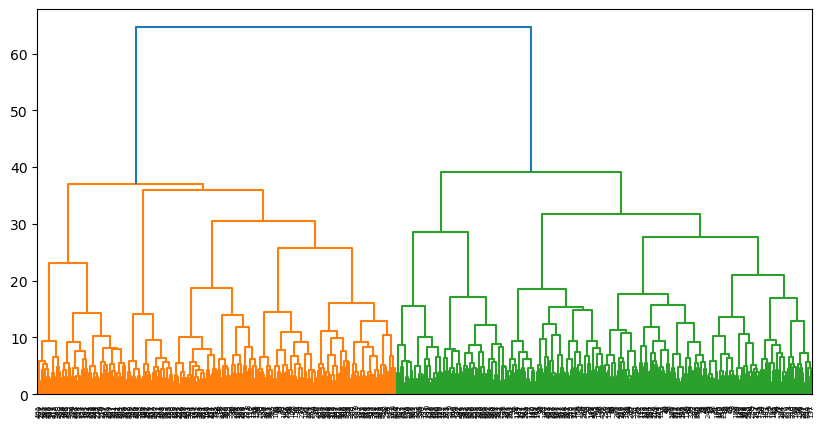

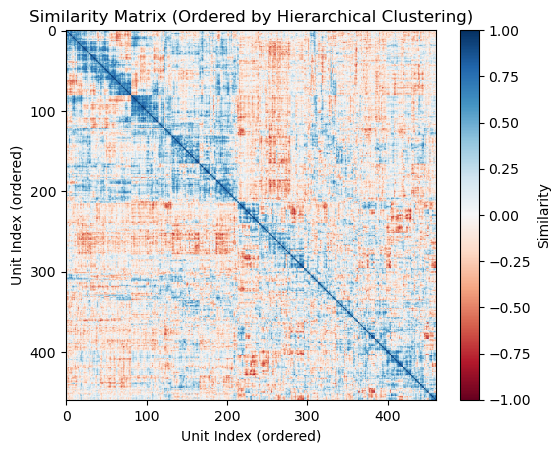

In [36]:
params = analysis.params
embed_matrix = params["params"]["embedding"]["encoder"]["encoder_matrix"]

# embed_matrix = params["params"]["rate_prediction"]["W_0"]
# embed_matrix = analysis.pca.transform(embed_matrix)

embed_matrix = embed_matrix / np.linalg.norm(embed_matrix, axis=1, keepdims=True)
sim = embed_matrix @ embed_matrix.T

# plt.imshow(sim, cmap="RdBu", vmin=-1, vmax=1)
# plt.colorbar()

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import leaves_list
from sklearn.cluster import SpectralClustering

# Perform hierarchical clustering on the similarity matrix
linked = linkage(sim, method="ward")
order = leaves_list(linked)

# Plot dendrogram
# plt.figure(figsize=(10, 5))
fig, ax = plt.subplots(
    nrows=1,
    height_ratios=[
        1,
    ],
    figsize=(10, 5),
    sharex=True,
)
dendrogram(linked, ax=ax)
# ax[0].set_title("Hierarchical Clustering Dendrogram")
# ax[0].set_xlabel("Unit Index")
# ax[0].set_ylabel("Distance")

# plt.figure(figsize=(8, 8))
# order = np.squeeze(np.argsort(np.squeeze(unit_cluster_id)))
c_rng = 1
fig = plt.figure()
plt.imshow(sim[order][:, order], aspect=1, cmap="RdBu", clim=(-c_rng, c_rng))
plt.title("Similarity Matrix (Ordered by Hierarchical Clustering)")
plt.xlabel("Unit Index (ordered)")
plt.ylabel("Unit Index (ordered)")
plt.colorbar(label="Similarity")
plt.show()